In [61]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
from collections import namedtuple
from datetime import date, timedelta

from algo.sde.ornstein_uhlenbeck_optimisation import calc_optimal_ou_params, log_likelihood_ou, ou_bet_size_loglikelihoods
from etl.yfinance_data import get_pairs_data


sns.set_style("darkgrid")

In [146]:
today = date.today()
end_date = today.strftime("%Y-%m-%d")

interval = "1h"
interval_map = {
    "1m": timedelta(minutes=60*24*7),
    # "1h": timedelta(hours=24*23*10),
    "1h": timedelta(hours=24*90),
    "1d": timedelta(days=365*1),   
}
test_size_map = {
    "1m": int(60*2),
    # "1h": int(24*23*1),
    # "1h": int(24*2),  # Good but HFT.
    "1h": int(24*7),  # Good - 1 week horizon.
    "1d": 30,   
}

num_test = test_size_map[interval]

# Let one unit of time be equivalent to one step in the data. TODO: later - clean data to rm. discontinuities (weekends etc.).
dt = 1

start_date = (today - interval_map[interval]).strftime("%Y-%m-%d")

# Works well, but WTI is physically settled. QM = mini CL, cash settled.
ticker1 = "BZ=F"
ticker2 = "CL=F"
df_raw = get_pairs_data(ticker1, ticker2, start_date, end_date, interval)

print(f"\nDates Requested: {start_date} to {end_date}")
print(f"Dates Received: {df_raw.index[0]} to {df_raw.index[-1]}\n")

df_raw.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Dates Requested: 2022-08-09 to 2022-11-07
Dates Received: 2022-08-08 19:00:00-04:00 to 2022-11-06 18:00:00-05:00



,S1,S2
2022-11-04 13:00:00-04:00,98.160004,92.010002
2022-11-04 14:00:00-04:00,98.800003,92.830002
2022-11-04 15:00:00-04:00,98.599998,92.639999
2022-11-04 16:00:00-04:00,98.639999,92.599998
2022-11-06 18:00:00-05:00,96.870003,90.690002


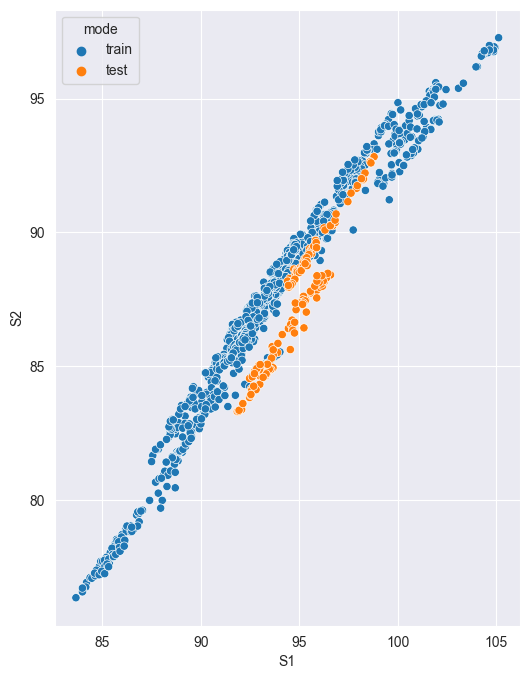

In [147]:
df_raw["mode"] = "train"
df_raw.loc[df_raw.index[-num_test:],"mode"] = "test"

# Assess linearity
sns.scatterplot(data=df_raw, x="S1", y="S2", hue="mode")
plt.show()

In [148]:
num_train = len(df_raw) - num_test

df = df_raw.head(num_train).copy()
df_test = df_raw.tail(num_test).copy()

len(df), len(df_test)

(1110, 168)

In [149]:
from operator import itemgetter


def hedging_parameters(asset1, asset2, A=1.0, start=0.001, end=1.0):
    alpha = A / asset1[0]

    num = int(1/start)
    B_candidates = np.linspace(start, end, num)

    log_likelihoods, ou_params_candidates = ou_bet_size_loglikelihoods(asset1, asset2, dt, alpha, B_candidates)

    # Optimise over log-likelihood
    i = np.argmax(log_likelihoods)
    ll_optimised = {
        "index": i,
        "log_likelihood": log_likelihoods[i],
        "ou_params": ou_params_candidates[i],
        "alpha": alpha,
        "beta": B_candidates[i] / asset2[0],
        "A": A,
        "B": B_candidates[i],
    }

    # Optimise over arbitrary OU param, e.g. mu is at index=1
    mu_index = 1
    j = ou_params_candidates.index(max(ou_params_candidates, key=itemgetter(mu_index)))
    mu_optimised = {
        "index": j,
        "log_likelihood": log_likelihoods[j],
        "ou_params": ou_params_candidates[j],
        "alpha": alpha,
        "beta": B_candidates[j] / asset2[0],
        "A": A,
        "B": B_candidates[j],
    }
    
    return ll_optimised, mu_optimised


hp_ll_opt, hp_mu_opt = hedging_parameters(asset1=df["S1"], asset2=df["S2"])

hp = hp_ll_opt
ll = hp["log_likelihood"]
ou_params = hp["ou_params"]
alpha = hp["alpha"]
beta = hp["beta"]
A = hp["A"]
B = hp["B"]

alpha, beta, A, B

(0.010375596892482132, 0.009535398069138687, 1.0, 0.862)

In [150]:
from statsmodels.tsa.stattools import adfuller


def print_adf_results(adf):
    _msg = lambda l: f"REJECT the hypothesis that S1 and S2 are NOT cointegrated at the {l} significance level"
    
    test_pass = False
    test_score = adf[0]
    thresholds = adf[4]
    for k, v in thresholds.items():
        if test_score < v:
            test_pass = True
            print(_msg(f"{k}"))
            
    if not test_pass:
        print("Failed to reject the null hypothesis - no cointegration.")
        
        
        
# Training set
df["spread"] = alpha*df["S1"] - beta*df["S2"]

adf = adfuller(df["spread"], maxlag=1)
print_adf_results(adf)

REJECT the hypothesis that S1 and S2 are NOT cointegrated at the 10% significance level


In [151]:
# Test set, under hedging parameters calibrated on the training set
df_test["spread"] = alpha*df_test["S1"] - beta*df_test["S2"]

adf_test = adfuller(df_test["spread"], maxlag=1)
print_adf_results(adf_test)

Failed to reject the null hypothesis - no cointegration.


In [152]:
# Simulate
from algo.sde.ornstein_uhlenbeck import OrnsteinUhlenbeck


x = df["spread"].to_numpy()

# TODO: check this - std_dev=dt!
# Test the process by running through an OU Model.
ou_model = OrnsteinUhlenbeck(X_0=x[0], theta=ou_params.theta, k=ou_params.mu, sigma=ou_params.sigma)
ou_process_simulated = ou_model(num_samples=len(x))
df["sim"] = ou_process_simulated

ou_params_sim = calc_optimal_ou_params(ou_process_simulated, dt)
ll_sim = log_likelihood_ou(theta=ou_params_sim.theta, mu=ou_params_sim.mu, sigma_sq=ou_params_sim.sigma_sq, x=ou_process_simulated, dt=dt)


def sim_results(ll, ll_sim, ou_params, ou_params_sim):
    # Want these differences to be as small as possible
    df_summary = pd.DataFrame(columns=["Real Data", "Sim", "% Diff"])
    df_summary["Real Data"] = [ou_params.theta, ou_params.mu, ou_params.sigma, ll]
    df_summary["Sim"] = [ou_params_sim.theta, ou_params_sim.mu, ou_params_sim.sigma, ll_sim]
    df_summary["% Diff"] = 100.0 * (df_summary["Real Data"] - df_summary["Sim"]) / df_summary["Real Data"]
    df_summary.index = ["theta", "mu", "sigma", "log_li"]
    
    return df_summary


df_summary = sim_results(ll, ll_sim, ou_params, ou_params_sim)
df_summary.round(3)

,Real Data,Sim,% Diff
theta,0.139,0.134,3.703
mu,0.016,0.021,-35.812
sigma,0.002,0.002,-0.000
log_li,4.980,4.984,-0.066


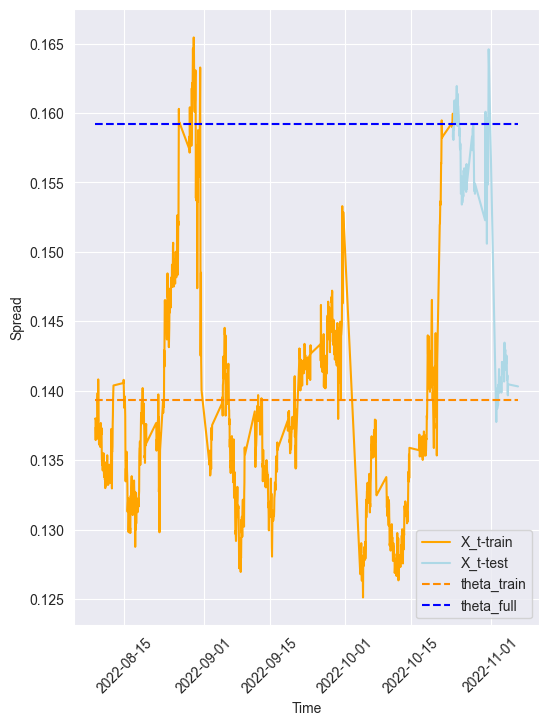

In [153]:
# Compare long-run mean in train set vs. full set (train+test).
hp_full, _ = hedging_parameters(asset1=df_raw["S1"], asset2=df_raw["S2"])
theta_full = hp_full["ou_params"].theta
theta_full


plt.plot(df.index, df["spread"], color="orange", label="X_t-train")
plt.plot(df_test.index, df_test["spread"], color="lightblue", label="X_t-test")
plt.hlines(ou_params.theta, xmin=df.index[0], xmax=df_test.index[-1], color="darkorange", linestyle="dashed", label="theta_train")
plt.hlines(theta_full, xmin=df.index[0], xmax=df_test.index[-1], color="blue", linestyle="dashed", label="theta_full")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Spread")
plt.xticks(rotation=45)
plt.show()

# Z-score analysis

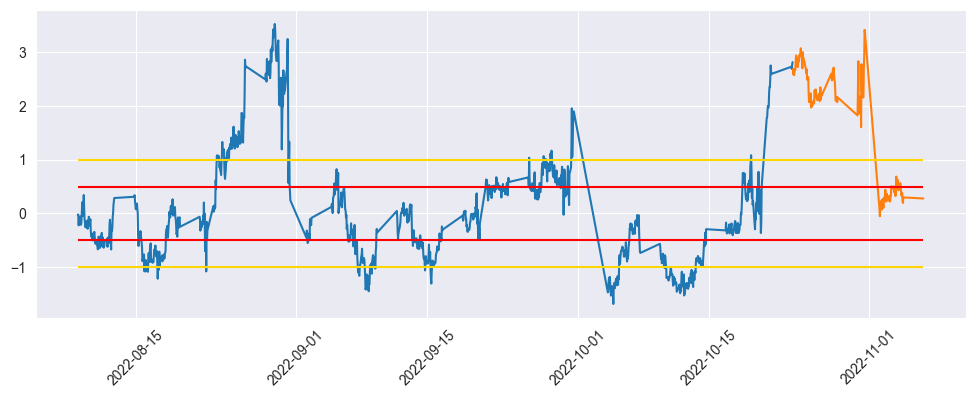

In [154]:
def zscore(x, mean, std_dev):
    """
    Args:
        x: 
        mean: E[x], or a lagged value thereof.
        std_dev: sqrt(Var[x]), or a lagged value thereof.
    """
    return (x - mean) / std_dev
    

def zscore_signals(df_in, z_entry_threshold, z_exit_threshold):
    """
    Args:
        x:
        z_entry_threshold: when to long the portfolio, i.e. enter market.
        z_exit_threshold: when to short the portfolio, i.e. exit market.
    
    Returns:
    
    """
    df = df_in.copy()

    # Cast bools -> floats
    df["long"] = 1.0*(df["zscore"] <= -z_entry_threshold)
    df["short"] = 1.0*(df["zscore"] >= z_entry_threshold)
    df["exit"] = 1.0*(np.abs(df["zscore"]) <= z_exit_threshold)
    
    return df


z_entry_threshold = 1.0
z_exit_threshold = 0.5

# Calibrate using only training set.
df["zscore"] = zscore(x=df["spread"], mean=df["spread"].mean(), std_dev=df["spread"].std())
df = df.pipe(zscore_signals, z_entry_threshold=z_entry_threshold, z_exit_threshold=z_exit_threshold)

# Test using the mean and std_dev of the training set.
df_test["zscore"] = zscore(x=df_test["spread"], mean=df["spread"].mean(), std_dev=df["spread"].std())
df_test = df_test.pipe(zscore_signals, z_entry_threshold=z_entry_threshold, z_exit_threshold=z_exit_threshold)


plt.figure(figsize=(12,4))
plt.plot(df.index, df["zscore"])
plt.plot(df_test.index, df_test["zscore"])
plt.hlines(
    [z_entry_threshold, -z_entry_threshold, z_exit_threshold, -z_exit_threshold],
    colors=["gold", "gold", "red", "red"],
    xmin=df.index[0],
    xmax=df_test.index[-1],
)
plt.xticks(rotation=45)
plt.show()

In [155]:
def compute_positions(df_in):
    df = df_in.copy()
    
    # Signals to demonstrate when to propagate positions forward:
    # - Stay long if: Z_exit_threshold < Z < Z_entry_threshold
    # - Stay short if: Z_entry_threshold < Z < Z_exit_threshold
    df["long_market"] = 0.0  # Must be float
    df["short_market"] = 0.0  # Must be float

    # Track whether to be long or short while iterating through each timestep
    long_market = 0.0  # Must be float
    short_market = 0.0  # Must be float

    # Calculate when to be in the market via holding a long or short position, and when to exit the market.
    # Hard to vectorise: note how `long_market` and `short_market` values are carried over in each loop iteration.
    long_markets = []
    short_markets = []
    for i, row in enumerate(df.iterrows()):
        if row[1]["long"] == 1.0:
            long_market = 1            
        if row[1]["short"] == 1.0:
            short_market = 1
        if row[1]["exit"] == 1.0:
            long_market = 0
            short_market = 0

        # Assign 1/0 to long_market/short_market to indicate when to stay in a position
        long_markets.append(long_market)
        short_markets.append(short_market)

    df["long_market"] = long_markets 
    df["short_market"] = short_markets
    df["positions"] = df["long_market"] - df["short_market"]

    # Using _pos to distinguish portfolio from raw.
    df["S1_pos"] = -1.0 * df["S1"] * df["positions"]
    df["S2_pos"] = df["S2"] * df["positions"]
    df["total"] = df["S1_pos"] + df["S2_pos"]

    return df


df = df.pipe(compute_positions)
df_test = df_test.pipe(compute_positions)

In [156]:
# TODO: S1_pos, S2_pos - made distinction to preserve data. Careful to propagate.

def compute_returns(df_in):
    df = df_in.copy()
    
    # Calculate simple percentage returns
    df["pc_returns"] = df["total"].pct_change()

    df["pc_returns"].fillna(0.0, inplace=True)
    df["pc_returns"].replace([np.inf, -np.inf], 0.0, inplace=True)
    df["pc_returns"].replace(-1.0, 0.0, inplace=True)

    # Accumulate returns across each time period
    df["returns"] = (1.0 + df["pc_returns"]).cumprod()

    # S1 and S2 correct here: comparing PF to buy-and-hold.
    df["returns_S1"] = (df["S1"].pct_change()+1.0).cumprod()
    df["returns_S2"] = (df["S2"].pct_change()+1.0).cumprod()

    return df

df = df.pipe(compute_returns)
df_test = df_test.pipe(compute_returns)

<AxesSubplot: >

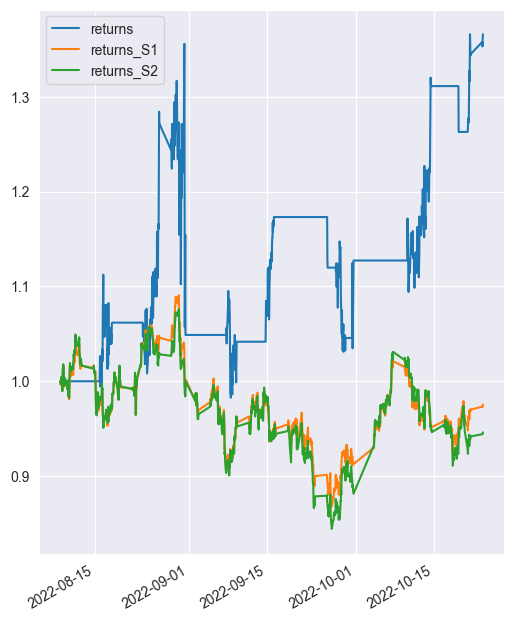

In [157]:
df[["returns", "returns_S1", "returns_S2"]].plot()

<AxesSubplot: >

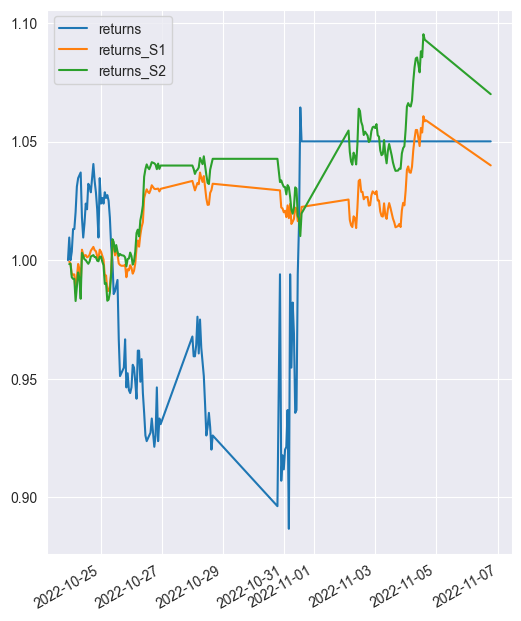

In [158]:
df_test[["returns", "returns_S1", "returns_S2"]].plot()

In [159]:
def sharpe_ratio_simple(df, colname="pc_returns"):
    sharpe = df[colname].mean() / df[colname].std()
    return sharpe
    
# sharpe_ratio = sharpe_ratio_simple(df)
# sharpe_ratio_test = sharpe_ratio_simp(df_test)


def sharpe_ratio_log(df, colname="total"):
    # Log returns are additive - better choice when doing *sqrt(252)
    log_returns = np.log(df[colname]/df[colname].shift())
    log_returns.fillna(0.0, inplace=True)
    log_returns.replace([np.inf, -np.inf], 0.0, inplace=True)

    sharpe = log_returns.mean()/log_returns.std()
    return sharpe


sharpe_ratio = sharpe_ratio_log(df)
sharpe_ratio_test = sharpe_ratio_log(df_test)


# Annualise: data is hourly. Futures: 23 hours in a trading day, 252 trading days in a year.
# Portfolio returns are a BM -> volatility scales with sqrt(time).
sharpe_ratio_annual = sharpe_ratio*np.sqrt(23*252)
sharpe_ratio_annual_test = sharpe_ratio_test*np.sqrt(23*252)

print(f"Sharpe Annual Train Set = {sharpe_ratio_annual}")
print(f"Sharpe Annual Test  Set = {sharpe_ratio_annual_test}")

Sharpe Annual Train Set = 1.5469791942118885
Sharpe Annual Test  Set = 1.197133807538257


/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/joe/miniforge3/envs/ml/lib/python3.9/site-packages/pandas/core/arraylike.py:405: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
